In [1]:
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial import cKDTree

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT, spatial_match
from scSLAT.viz import match_3D_multi, hist, Sankey
from scSLAT.metrics import region_statistics

In [8]:
def find_rigid_transform(A, B):
    assert A.shape == B.shape

    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)


    A_centered = A - centroid_A
    B_centered = B - centroid_B

    H = A_centered.T @ B_centered

    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

def rotation_angle_2d(R):
    theta = np.arctan2(R[1, 0], R[0, 0])
    return np.degrees(theta)
def evaluation(src_cor, tgt_cor, src_exp, tgt_exp, src_cell_type, tgt_cell_type):

    kd_tree = cKDTree(src_cor)
    distances, indices = kd_tree.query(tgt_cor, k=1) 
    corr = np.corrcoef(np.concatenate((tgt_exp,src_exp[indices]), axis=0))[:tgt_exp.shape[0],tgt_exp.shape[0]:]
    acc = corr.trace()/tgt_exp.shape[0]
    cri = np.mean((tgt_cell_type == src_cell_type[indices])+0)
    #euc = np.mean((ori_src_cor-src_cor)**2)
    
    return acc, cri
def simulate_stitching(adata,axis = 0, from_low = True, threshold = 0.5):
    cadata = adata.copy()
    coo = cadata.obsm['spatial']
    scale = np.max(coo[:, axis]) - np.min(coo[:, axis])
    if from_low:
        chosen_indices = coo[:,axis] > (scale * threshold + np.min(coo[:, axis]))
    else:
        chosen_indices = coo[:,axis] < (np.max(coo[:, axis]) - scale * threshold)
    cadata = cadata[chosen_indices,:]
    return cadata
def intersect(lst1, lst2):
    temp = set(lst2)
    lst3 = [value for value in lst1 if value in temp]
    return lst3


Calculating spatial neighbor graph ...
The graph contains 97136 edges, 8506 cells.
11.419703738537503 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 111723 edges, 9803 cells.
11.396817300826278 neighbors per cell on average.
Use raw feature to format graph
Choose GPU:1 as device
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 33.46


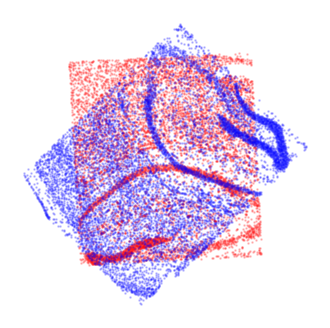

In [9]:
### STARmap PLUS (rotate 45 degree)


adata1 = sc.read_h5ad('../Dataset/8month_cr1_example_align.h5ad')
adata2 = sc.read_h5ad('../Dataset/8month_cr2_example_align.h5ad')

src_cor = np.array(adata1.obsm['spatial'])
tgt_cor = np.array(adata2.obsm['spatial'])
radian = math.radians(45)
rotation = np.array([[ np.cos(radian), -np.sin(radian)],
                     [np.sin(radian),  np.cos(radian)]])

tgt_cor = np.dot(tgt_cor, rotation.T)

adata2.obsm['spatial'] = tgt_cor
adata1.obsm['spatial'] = src_cor

sc.pp.normalize_total(adata1)
sc.pp.normalize_total(adata2)

Cal_Spatial_Net(adata1, k_cutoff=10, model='KNN')
Cal_Spatial_Net(adata2, k_cutoff=10, model='KNN')
edges, features = load_anndatas([adata1, adata2], feature='raw',check_order=False)
embd0, embd1, time = run_SLAT(features, edges)
best, index, distance = spatial_match(features, adatas=[adata1,adata2], reorder=False)
matching = np.array([range(index.shape[0]), best])
R,T = find_rigid_transform(adata1.obsm['spatial'][matching[1,:]],adata2.obsm['spatial'])
adata1.obsm['align_spatial'] = np.dot(adata1.obsm['spatial'], R.T) + T

plt.figure(figsize=(4,4))
plt.scatter(adata1.obsm['align_spatial'][:,0],adata1.obsm['align_spatial'][:,1],c='r',label='align_source',alpha=0.2,s=0.8)
plt.scatter(adata2.obsm['spatial'][:,0],adata2.obsm['spatial'][:,1],c='b',label='target',alpha=0.2,s=0.8)
plt.axis('off')
plt.legend()
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()


/tmp/ipykernel_21404/4138354301.py:20: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  adata1.obsm['spatial'] = src_cor
/tmp/ipykernel_21404/4138354301.py:21: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  adata2.obsm['spatial'] = tgt_cor


Calculating spatial neighbor graph ...
The graph contains 41731 edges, 3961 cells.
10.535470840696794 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 42389 edges, 4057 cells.
10.448360857776683 neighbors per cell on average.
Use PCA feature to format graph


/home/lih0m/anaconda3/envs/scSLAT3/lib/python3.9/site-packages/scSLAT/model/loaddata.py:224: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_all = adatas[0].concatenate(adatas[1], join=join) # join can not be 'outer'!


Choose GPU:1 as device
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 5.20


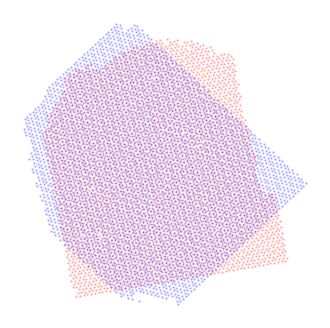

In [11]:
### DLPFC stitching (rotate 45 degree, 80% overlap)

train_ad1 = sc.read_h5ad('../Dataset/151507_preprocessed.h5')
train_ad2 = sc.read_h5ad('../Dataset/151508_preprocessed.h5')
train_ad1.X = np.array(train_ad1.X.todense())
train_ad2.X = np.array(train_ad2.X.todense())

adata1 = simulate_stitching(train_ad1, axis=0, from_low=True, threshold=0.1)
adata2 = simulate_stitching(train_ad2, axis=0, from_low=False, threshold=0.1)
train_ad1_part_overlap_index = adata1.obsm['spatial'][:,0] < np.max(adata2.obsm['spatial'][:,0])
train_ad2_part_overlap_index = adata2.obsm['spatial'][:,0] > np.min(adata1.obsm['spatial'][:,0])

src_cor = np.array(adata1.obsm['spatial'])
tgt_cor = np.array(adata2.obsm['spatial'])
radian = math.radians(45)
rotation = np.array([[np.cos(radian), -np.sin(radian)],
                     [np.sin(radian),  np.cos(radian)]])

tgt_cor = np.dot(tgt_cor, rotation.T)
adata1.obsm['spatial'] = src_cor
adata2.obsm['spatial'] = tgt_cor

Cal_Spatial_Net(adata1, k_cutoff=10, model='KNN')
Cal_Spatial_Net(adata2, k_cutoff=10, model='KNN')
edges, features = load_anndatas([adata1, adata2], feature='PCA',check_order=False)
embd0, embd1, time = run_SLAT(features, edges)
best, index, distance = spatial_match(features, adatas=[adata1,adata2], reorder=False)
matching = np.array([range(index.shape[0]), best])
R,T = find_rigid_transform(adata1.obsm['spatial'][matching[1,:]],adata2.obsm['spatial'])
adata1.obsm['align_spatial'] = np.dot(adata1.obsm['spatial'], R.T) + T

plt.figure(figsize=(4,4))
plt.scatter(adata1.obsm['align_spatial'][:,0],adata1.obsm['align_spatial'][:,1],c='r',label='align_source',alpha=0.2,s=0.8)
plt.scatter(adata2.obsm['spatial'][:,0],adata2.obsm['spatial'][:,1],c='b',label='target',alpha=0.2,s=0.8)
plt.axis('off')
plt.legend()
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()


Calculating spatial neighbor graph ...
The graph contains 284233 edges, 5279 cells.
53.842204963061185 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 290077 edges, 5361 cells.
54.10874836784182 neighbors per cell on average.
Use raw feature to format graph
Choose GPU:1 as device
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 8.09
Calculating spatial neighbor graph ...
The graph contains 290077 edges, 5361 cells.
54.10874836784182 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 285070 edges, 5284 cells.
53.949659348978045 neighbors per cell on average.
Use raw feature to format graph
Choose GPU:1 as device
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 -----

/home/lih0m/anaconda3/envs/scSLAT3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


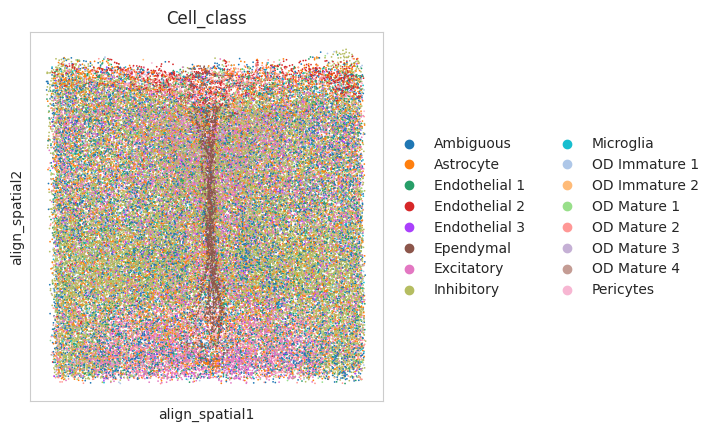

In [34]:
### MERFISH dataset

adata = sc.read_h5ad('../Dataset/MERFISH.h5ad')
slice_ids = np.unique(adata.obs.Bregma)
slice_ids[::-1].sort()
cor = np.array(adata.obsm['spatial'])

for i in range(len(slice_ids)-1):
    adata1 = adata[adata.obs.Bregma == slice_ids[i],:].copy()
    adata2 = adata[adata.obs.Bregma == slice_ids[i+1],:].copy()
    Cal_Spatial_Net(adata1, k_cutoff=50, model='KNN')
    Cal_Spatial_Net(adata2, k_cutoff=50, model='KNN')
    edges, features = load_anndatas([adata1, adata2], feature='raw',check_order=False)
    embd0, embd1, time = run_SLAT(features, edges)
    best, index, distance = spatial_match(features, adatas=[adata1,adata2], reorder=False)
    matching = np.array([range(index.shape[0]), best])
    R,T = find_rigid_transform(adata1.obsm['spatial'][matching[1,:]],adata2.obsm['spatial'])
    cor[np.isin(adata.obs.Bregma,slice_ids[:i]),:] = np.dot(cor[np.isin(adata.obs.Bregma,slice_ids[:i]),:], R.T) + T

adata.obsm['align_spatial'] = cor
sc.pl.spatial(adata,color='Cell_class',spot_size=10,basis='align_spatial')